# DeepSAR demo

This notebook demonstrates the workflow for running DeepSAR, including model initialization, data processing, and prediction.

## Setting up the environment (for use in Colab)
Please choose under `Resources` a GPU environment.

The cells below install all dependencies on the current Colab kernel, and download the necessary data. Once this is done, you'll be asked to restart the Colab kernel before executing the actual Python code, to ensure that the environment is set up correctly.
### Installing dependencies

In [ ]:
!git clone https://github.com/vboussange/deepsar.git
%cd deepsar/
!uv sync;
!uv pip install torch --torch-backend=auto;
!uv pip install -e .
!source .venv/bin/activate


fatal: destination path 'deepsar' already exists and is not an empty directory.
Resolved 99 packages in 11ms
Uninstalled 1 package in 0.93ms
 - deepsar==0.1.0 (from file:///home/boussang/NNSAR)
Audited 1 package in 4ms
Resolved 94 packages in 167ms                                        
   Building deepsar @ file:///home/boussang/NNSAR                      
   Building deepsar @ file:///home/boussang/NNSAR              
   Building deepsar @ file:///home/boussang/NNSAR              
      Built deepsar @ file:///home/boussang/NNSAR              
Prepared 1 package in 549ms                                              
Installed 1 package in 6msm file:///home/boussang/NNSAR)    
 + deepsar==0.1.0 (from file:///home/boussang/NNSAR)


### Downloading data

In [ ]:
!cd data/raw/CHELSA/ && wget --no-host-directories --force-directories --input-file=envidat.txt

<div style="border:2px solid #f44336; background-color:#ffebee; color:#b71c1c; padding:16px; border-radius:6px; font-weight:bold;">
⚠️ Now, <b>restart the session</b> (down arrow next to the tab <code>Run all</code>) to ensure that the environment is set up correctly.
</div>

## Predicting species richness with DeepSAR

In [ ]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
from deepsar.data_processing.utils_env_pred import CHELSADataset
from deepsar.plotting import CMAP_BR
from deepsar.deep4pweibull import Deep4PWeibull

import pandas as pd
from tqdm import tqdm

def create_raster(gdf, ypred):
    """Converts a geodataframe `gdf` with column `pred`
    into a raster format.
    """
    Xy_map = gdf.copy()
    Xy_map["pred"] = ypred
    rast = Xy_map["pred"].to_xarray().sortby(["y","x"])
    rast = xr.DataArray(rast.values, dims=["y", "x"], coords={
                            "x": rast.x.values,  # X coordinates (easting)
                            "y": rast.y.values,  # Y coordinates (northing)
                        },
                        name="pred")
    rast = rast.rio.write_crs("EPSG:3035")
    return rast

def create_features(climate_dataset, res, model):
    """
    Given a `climate_dataset`, creates a dataframe with features
    required for `model`, calculated at a specified resolution `res`.
    """
    # see: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.coarsen.html
    resolution = abs(climate_dataset.rio.resolution()[0])
    ncells = max(1, int(res / resolution))
    coarse = climate_dataset.coarsen(x=ncells, y=ncells, boundary="trim")

    # See: https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_array.RasterArray.reproject_match
    coarse_mean = coarse.mean().rio.write_crs("EPSG:3035")#.rio.reproject_match(ref)
    coarse_std = coarse.std().rio.write_crs("EPSG:3035")#.rio.reproject_match(ref)
    df_mean = coarse_mean.to_dataframe()
    df_std = coarse_std.to_dataframe()
    df_std = df_std.rename({col: "std_" + col for col in df_std.columns}, axis=1)
    gdf = pd.concat([df_mean, df_std], axis=1)
    gdf = gdf.assign(log_sp_unit_area=np.log(res**2))
    return gdf[model.feature_names]

def batch_predict(model, climate_dataset, res, batch_size=2**13):
    """
    Returns a geodataframe containing species richness estimates and standard
    deviation for the given ensemble `model` and `climate dataset` at a specified
    resolution `res`.
    """
    mean_SR_list = []
    std_SR_list = []
    features = create_features(climate_dataset, res, model)
    total_length = len(features)

    percent_step = max(1, total_length // batch_size // 100)

    for i in tqdm(range(0, total_length, batch_size), desc = "Calculating SR and stdSR", miniters=percent_step, maxinterval=float("inf")):
        with torch.no_grad():
            current_batch_size = min(batch_size, total_length - i)
            X = features.iloc[i:i+current_batch_size,:]
            mean_SR_list.append(model.predict_mean_sr_tot(X))
            std_SR_list.append(model.get_std_sr_tot(X))

    mean_SR = np.concatenate(mean_SR_list, axis=0)
    std_SR = np.concatenate(std_SR_list, axis=0)
    return features, mean_SR, std_SR


## Loading model and environmental features

In [2]:
# Loading model weights and configuration
model_name = "checkpoint_deep4pweibull_basearch6_0b85791"
plotting = True

path_results = Path(f"scripts/results/train/{model_name}.pth")
checkpoint = torch.load(path_results, map_location="cpu", weights_only=False)

model = Deep4PWeibull.initialize_ensemble(checkpoint)

In [3]:
# Loading CHELSA dataset (environmental features)
climate_dataset = CHELSADataset().load()
climate_dataset = climate_dataset[[v for v in climate_dataset.data_vars if v in checkpoint["config"].predictors]]
climate_dataset = climate_dataset.rio.reproject("EPSG:3035")

print(list(climate_dataset.data_vars))

['bio1', 'bio4', 'bio12', 'bio15', 'sfcWind_mean', 'pet_penman_mean', 'rsds_1981-2010_range_V.2.1']


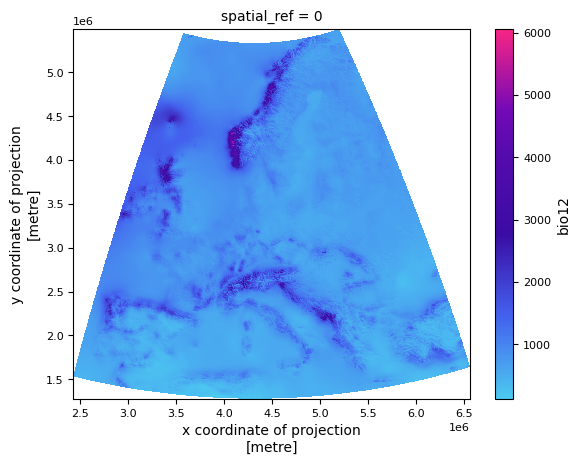

In [4]:
climate_dataset["bio12"].coarsen(x=4, y=4, boundary="trim").mean().plot(cmap=CMAP_BR)

Now we are ready to make predictions!

/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=d

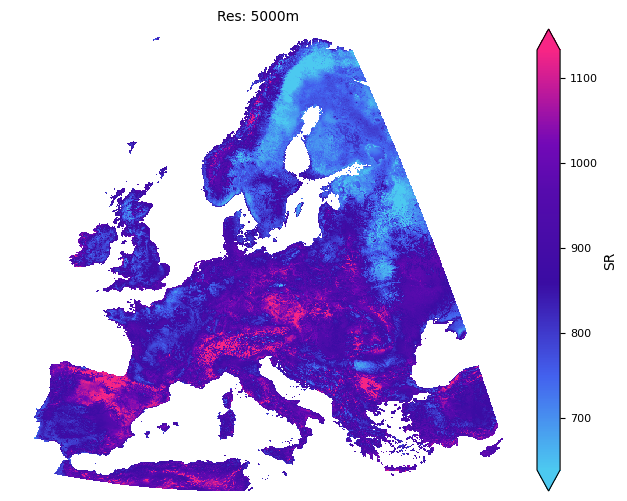

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
    
res = 5000 # pixel size (unit for sampling area), in meters

features, SR, std_SR = batch_predict(model, climate_dataset, res) # predict in batches, returns a dataframe
# we use batches, otherwise model and data may not fit in memory

SR_rast = create_raster(features, SR) # transform dataframe to raster format
    
# plotting
fig, ax = plt.subplots(figsize=(8, 6))
SR_rast = SR_rast.rename("SR")
SR_rast.plot(ax=ax, cmap=CMAP_BR, vmin=SR_rast.quantile(0.01), vmax=SR_rast.quantile(0.99))
ax.set_title(f"Res: {res}m")
ax.set_axis_off()


## Saving raster

In [6]:
SR_rast.rio.to_raster(f"SR_raster_{model_name}_{res:.0f}m.tif")

You can now download the raster under the `Files` tab in Colab.

## Bonus
Although our model has been trained over Europe, we could also use it to predict species richness in, for example, the US. 🤪 Of course, this is not scientifically sound, as the biota there is very different from Europe, but for pedagogical purposes, we show here how to proceed.

In [7]:
climate_dataset = CHELSADataset().load(extent=(-125, 24, -66.5, 49))
climate_dataset = climate_dataset[[v for v in climate_dataset.data_vars if v in checkpoint["config"].predictors]]
climate_dataset = climate_dataset.rio.reproject("EPSG:2163")

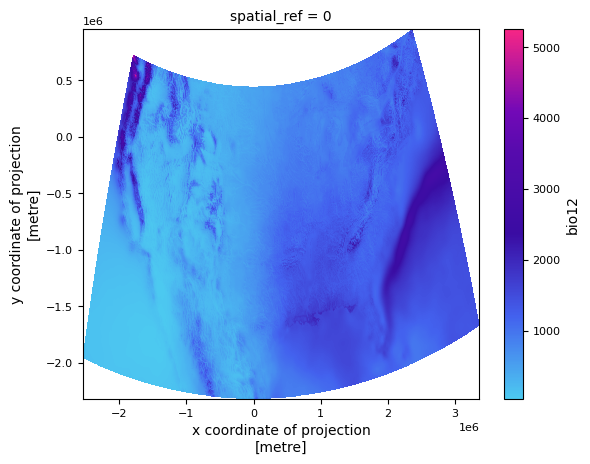

In [8]:
climate_dataset["bio12"].coarsen(x=4, y=4, boundary="trim").mean().plot(cmap=CMAP_BR)

/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/boussang/NNSAR/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=d

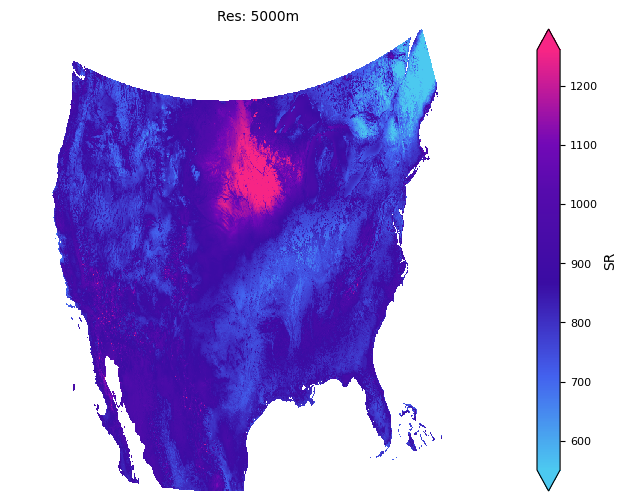

In [ ]:
res = 5000
features, SR, std_SR = batch_predict(model, climate_dataset, res)
SR_rast = create_raster(features, SR)
fig, ax = plt.subplots(figsize=(8, 6))
SR_rast = SR_rast.rename("SR")
SR_rast.plot(ax=ax, cmap=CMAP_BR, vmin=SR_rast.quantile(0.01), vmax=SR_rast.quantile(0.99))
ax.set_title(f"Res: {res}m")
ax.set_axis_off()